In [1]:
import os
import time
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import pyabf
import utils

## Start with mouse 2019 data

In [2]:
mouse_meta = pd.read_csv('./data/raw/Metadata/Mouse19_Metadatav2.csv')
mouse_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
mouse_meta.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP
0,19o22017,Mouse,Oct 22_2019,C2,L5,Firing,After ZD,shortsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-66.0
1,19o22001,Mouse,Oct 22_2019,C2,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-64.0
2,19o22031,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-70.0
3,19o22037,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 11(pA),-67.0
4,19o22018,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-75.0


In [4]:
mouse_meta['Stim Type'].value_counts()

Firing         58
White noise    52
Firing rate     5
Gap free        5
ZAP             3
GAP free        1
n.a             1
Name: Stim Type, dtype: int64

In [5]:
intrinsic_meta = mouse_meta[(mouse_meta['Stim Type'] == 'Firing') | (mouse_meta['Stim Type'] == 'Firing rate')]

In [6]:
intrinsic_meta['Stim Type'].value_counts()

Firing         58
Firing rate     5
Name: Stim Type, dtype: int64

## Identify files to be converted
- ABF files from mouse2019
- need metadata to determine which files are testing intrinsic properties
- extract ABF version info, time of creation and comments from the ABF file

In [7]:
mouse2019_abf_dir = Path("./data/raw/recordings/Mouse data/Mouse data_2019/")
mouse2019_file_info = utils.summary_df(mouse2019_abf_dir)

# NOTE
can probably remove the following cell.
probably keep file_id and experimenter

In [8]:
%%time
def check_protocolpath_for_experimenter(abf_path):
    abf = pyabf.ABF(abf_path)
    if 'Homeira' in abf.protocolPath:
        return 'Homeira'
    elif 'Lihua' in abf.protocolPath:
        return 'Lihua'
    else:
        #print(abf.protocolPath)
        return None

mouse2019_file_info['experimenter'] = mouse2019_file_info.path.apply(check_protocolpath_for_experimenter)

# add this column to merge with provided metadata
mouse2019_file_info['file_id'] = mouse2019_file_info.file_name.apply(lambda x: Path(x).stem) 

CPU times: user 805 ms, sys: 365 ms, total: 1.17 s
Wall time: 1.35 s


In [9]:
mouse2019_file_info = mouse2019_file_info[~(mouse2019_file_info.path.str.contains('KA') | 
                                            mouse2019_file_info.path.str.contains('CA') | 
                                            mouse2019_file_info.path.str.contains('4AP'))]

In [10]:
mouse2019_file_info.shape

(63, 4)

In [11]:
merged_meta = intrinsic_meta.merge(mouse2019_file_info, left_on='Cell Name', right_on='file_id' , how='left').drop('Cell Name', axis=1)

In [12]:
merged_meta['ZD status'].value_counts()

n.a          37
After ZD      8
Before ZD     8
After CA      5
Before CA     5
Name: ZD status, dtype: int64

In [13]:
# drop recordings where ZD was applied
merged_meta = merged_meta[merged_meta['ZD status'] != 'After ZD']
merged_meta = merged_meta[merged_meta['ZD status'] != 'After CA']

In [14]:
merged_meta.shape

(50, 16)

In [15]:
merged_meta.dropna(subset=['path'], inplace=True)

In [16]:
merged_meta.shape

(16, 16)

In [17]:
merged_meta

,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP,file_name,path,experimenter,file_id
1,Mouse,Oct 22_2019,C2,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-64.0,19o22001.abf,data/raw/recordings/Mouse data/Mouse data_2019...,Homeira,19o22001
4,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-75.0,19o22018.abf,data/raw/recordings/Mouse data/Mouse data_2019...,Homeira,19o22018
5,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,shortsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-75.0,19o22019.abf,data/raw/recordings/Mouse data/Mouse data_2019...,Homeira,19o22019
6,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 11(pA),-77.0,19o22020.abf,data/raw/recordings/Mouse data/Mouse data_2019...,Homeira,19o22020
11,Mouse,Oct 23_2019,C4,L5,Firing,Before ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 10(pA),-62.0,19o23019.abf,data/raw/recordings/Mouse data/Mouse data_2019...,Homeira,19o23019
15,Mouse,Oct 23_2019,C8,L5,Firing,Before ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 10(pA),-68.0,19o23056.abf,data/raw/recordings/Mouse data/Mouse data_2019...,Homeira,19o23056
47,Mouse,Oct 23_2019,C1,L5,Firing,n.a,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-62.0,19o23001.abf,data/raw/recordings/Mouse data/Mouse data_2019...,Homeira,19o23001
48,Mouse,Oct 23_2019,C2,L5,Firing,n.a,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-66.0,19o23003.abf,data/raw/recordings/Mouse data/Mouse data_2019...,Homeira,19o23003
49,Mouse,Oct 23_2019,C2,L5,Firing,n.a,shortsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-67.0,19o23005.abf,data/raw/recordings/Mouse data/Mouse data_2019...,Homeira,19o23005
50,Mouse,Oct 23_2019,C2,L5,Firing,n.a,ramp,1.0,0.0,Vm_Sec (mV),IN 10(pA),-67.0,19o23006.abf,data/raw/recordings/Mouse data/Mouse data_2019...,Homeira,19o23006


In [18]:
merged_meta = merged_meta[merged_meta.stimulus_type == 'longsquare']

In [19]:
# sweep through all listed abf files and extract all relevant metadata required to parse raw data
results_list = []
for i, row in merged_meta.iterrows():
    
    resp_chan = 0
    stim_chan = 0
    stim_info_dict = {}
    
    abf = pyabf.ABF(row.path)
    num_sweeps = abf.sweepCount
    abf_tag = abf.tagComments
    if abf_tag:
        abf_tag = abf_tag[0]
    else:
        abf_tag = None
    print(row.path)
    print(abf_tag)
    
    if len(abf.channelList) == 3:
        #print(abf_file)
        stim_chan = 2
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 1
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = 10
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 
                          'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
        print(stim_dict)
        
    elif len(abf.channelList) == 4:

        stim_chan = 3
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 2
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = .2
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
    else:
        # figure out response channel
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        resp_sampling_rate = int(round(1/(abf.sweepX[2] - abf.sweepX[1]))) # manually calculate the sampling rate

        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)

        stim_name = 'sweepC'
        
        cell_meta_df = None
        try:
            stim_dict = utils.get_stim_dict2(row, cell_meta_df, stim_name)
        except AttributeError as e:
            print(e)
        
        # if in the odd case the number of sweeps doesn't match between resp vs stim file, then make them match
    print(f'num_sweeps: {num_sweeps}')
    print(f'stim_dict: {stim_dict}')
    if num_sweeps != stim_dict['num_sweeps']:
        #print(abf_file)
        stim_dict['num_sweeps'] = num_sweeps
        stim_dict['stim_amp_vec'] = stim_dict['stim_amp_vec'][0:num_sweeps]
        
    ret_dict = {'cell_id' : row.file_id, 'resp_chan' : resp_chan, 
                'resp_gain' : best_gain, 'rmp_error' : rmp_abs_error, 'abf_tag' : abf_tag,
                'rmp_val' : row.RMP, 'resp_offset' : row.Offset,
                'abf_version' : abf.abfVersionString, 'resp_sampling_rate' : resp_sampling_rate, 'stim_name' : stim_name, 
               'file_time' : abf.abfDateTime}
    #ret_dict = dict(ret_dict.items() + stim_info_dict.items())
    ret_dict.update(stim_dict)
    #print(ret_dict)

    results_list.append(ret_dict)
    print('--'*50)

data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/Before ZD/19o22001.abf
C2, L5, APV,CNQX,PTX
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 15
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/Before ZD/19o22001.abf', 'valid_stim': True, 'stim_amp_vec': array([-300., -250., -200., ...,  300.,  350.,  400.]), 'stim_duration': 0.6, 'stim_start_time': 0.0921, 'stim_end_time': 0.69205, 'num_sweeps': 15, 'stim_sampling_rate': 20000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/Before ZD/19o22018.abf
C3, L5, APV,CNQX,PTX
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 14
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/Before ZD/19o22018.abf', 'valid_stim': True, 'stim_amp_vec': array([-300.,

In [20]:
extracted_meta = pd.DataFrame(results_list)

In [21]:
all_meta = merged_meta.merge(extracted_meta, left_on='file_id', right_on='cell_id')

In [22]:
meta_path = Path('./data/processed/meta')
meta_path.mkdir(exist_ok=True)
all_meta.to_csv(meta_path / 'm2019_meta.csv')

In [23]:
all_meta.iloc[0]

Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before ZD
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                               -64.0
file_name                                                  19o22001.abf
path                  data/raw/recordings/Mouse data/Mouse data_

## Convert

In [24]:
output_dir = Path("data/processed/recordings/mouse/m2019")
output_dir.mkdir(exist_ok=True, parents=True)

In [25]:
from x_to_nwb import ABF2Converter
from x_to_nwb import ABF1Converter

In [26]:
all_meta.iloc[0]

Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before ZD
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                               -64.0
file_name                                                  19o22001.abf
path                  data/raw/recordings/Mouse data/Mouse data_

In [27]:
%%time
errors = []

for i, file_info in all_meta.iterrows():
    print(file_info)
    try:
        abf = pyabf.ABF(file_info.path) # abf file to be converted
        file_stem = file_info.cell_id # file stem with no file type
        
        # figure out if stimulus is on dac or adc channels
        if file_info.stim_name == 'sweepC': 
            stim_chan = abf.dacNames[file_info.stim_chan] 
        else: #if stim_name is sweepY
            stim_chan = abf.adcNames[file_info.stim_chan] 
        
        resp_chan = abf.adcNames[file_info.resp_chan] # response seems always to be in adc channels
        
        # this should be populated with metadata from homeira!
        meta = {
            'Subject': {
                'age': 'P21D',
                'description': f'{file_info.abf_tag}',
                'species': 'Mus musculus',
                'subject_id': f'subject-{file_info["Exp. Date"]}-{file_info["Cell #"]}'
            }
        }

        
        output_path = output_dir / f'{file_stem}.nwb'
        
        if file_info.abf_version == '2.6.0.0': # if abf v2 file
            # i didn't use gain here because none of my abf v2 files needed a gain - feel free to add one though
            nwb = ABF2Converter.ABF2Converter(file_info.path, 
                                              str(output_path), 
                                              includeChannelList=[resp_chan], 
                                              stimulus_name=stim_chan, 
                                              metadata=meta)
        
        else: # if abf 1 file
            nwb = ABF1Converter.ABF1Converter(inputPath = file_info.path, 
                                              outputFilePath = str(output_path), 
                                              acquisitionChannelName = resp_chan, 
                                              stimulusChannelName = stim_chan,
                                              metadata=meta, 
                                              responseGain = file_info.resp_gain, # gain on response channel
                                              stimulusGain = file_info.stim_gain, # gain on stimulus channel
                                              responseOffset = file_info.resp_offset) # voltage offset on resp channel
            nwb.convert()
        print(nwb)
        print("NWB Conversion complete for " + file_stem +'.nwb\n')
        print('--'*50)
        
    except (ValueError, IndexError, TypeError, KeyError, UnicodeDecodeError,AttributeError) as e:
        print('**'*50)
        print(f'Error: {e} \n {file_info.path} \n')
        errors.append((e, file_info.file_id, file_info.path))

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/Before ZD/19o22001.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before ZD
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                               -64.0
file_name                                                  19o22001.abf
path                  data/raw/recordings/Mouse data/Mouse data_

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset I-V curve ,-400 pA, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:550: UserWarning: Could not find settings for amplifier unknown of channel Vm_sec.
  warnings.warn(f"Could not find settings for amplifier {amplifier} of channel {adcName}.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/Before ZD/19o22018.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o22001.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 22_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                     Before ZD
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C1_L5/Firing/19o23001.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o22018.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C2_L5/Firing/19o23003.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23001.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C3_L5/Firing/19o23010.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23003.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C7_L5/Firing/19o23046.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23010.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C7
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C6_L5/Firing rate/19o23039.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o23046.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Oct 23_2019
Cell #                                                               C6
Cell Layer                                                           L5
Stim Type                                                   Firing rate
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                              0.0
Response Channel                                            Vm_Sec (mV)
Command Channel                                               IN 11(pA)
RMP                                                              

## Plot NWB files

In [28]:
ontology_path = "./data/stim_ontology_new_Homeira.json"

nwb_files = utils.summary_df(path=Path('./data/processed/recordings/mouse2019/'), suffix='.nwb')

In [29]:
for i, row in nwb_files.sort_values('file_name').iterrows():
    utils.plot_nwb_sweep(file_name=row.path, ontology=ontology_path)

In [30]:
!dandi validate ./data/processed/recordings/mouse/m2019

2022-01-26 11:21:49,667 [ WARNING] A newer version (0.35.0) of dandi/dandi-cli is available. You are using 0.34.1
2022-01-26 11:21:49,958 [    INFO] NumExpr defaulting to 8 threads.
2022-01-26 11:21:53,088 [    INFO] ./data/processed/recordings/mouse/m2019/19o23003.nwb: ok
2022-01-26 11:21:55,293 [    INFO] ./data/processed/recordings/mouse/m2019/19o23001.nwb: ok
2022-01-26 11:21:58,213 [    INFO] ./data/processed/recordings/mouse/m2019/19o23010.nwb: ok
2022-01-26 11:22:01,073 [    INFO] ./data/processed/recordings/mouse/m2019/19o23039.nwb: ok
2022-01-26 11:22:03,309 [    INFO] ./data/processed/recordings/mouse/m2019/19o22018.nwb: ok
2022-01-26 11:22:05,478 [    INFO] ./data/processed/recordings/mouse/m2019/19o22001.nwb: ok
2022-01-26 11:22:07,730 [    INFO] ./data/processed/recordings/mouse/m2019/19o23046.nwb: ok
Summary: No validation errors among 7 file(s)
2022-01-26 11:22:07,731 [    INFO] Logs saved in /Users/derek_howard/Library/Logs/dandi-cli/20220126162149Z-11742.log


# Mouse 2018

In [31]:
mouse18_meta = pd.read_csv('./data/raw/Metadata/Mouse18_Metadatav2.csv')
mouse18_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [32]:
mouse18_meta.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP
0,18116450,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5
1,18130014,Mouse,Jan 30_2018,C5,L5,Firing,n.a,longsquare,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2
2,2018_02_08_0000,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,ramp,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
3,2018_02_08_0001,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,longsquare,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
4,18208013,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,ramp,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3


In [33]:
mouse18_meta['Stim Type'].value_counts()

Gain 40           62
Gain 20           14
Firing pattern    11
Firing             2
Name: Stim Type, dtype: int64

In [34]:
intrinsic_meta = pd.concat([mouse18_meta[mouse18_meta['Stim Type'] == 'Firing'], mouse18_meta[mouse18_meta['Stim Type'] == 'Firing pattern']])

In [35]:
mouse2018_abf_dir = Path("./data/raw/recordings/Mouse data/Mouse data_2018")
mouse2018_file_info = utils.summary_df(mouse2018_abf_dir)

In [36]:
mouse2018_file_info['experimenter'] = mouse2018_file_info.path.apply(check_protocolpath_for_experimenter)

# add this column to merge with provided metadata
mouse2018_file_info['file_id'] = mouse2018_file_info.file_name.apply(lambda x: Path(x).stem) 

In [37]:
mouse2018_file_info.shape

(124, 4)

In [38]:
mouse2018_file_info

,file_name,path,experimenter,file_id
0,18130005.abf,data/raw/recordings/Mouse data/Mouse data_2018...,Homeira,18130005
1,18130004.abf,data/raw/recordings/Mouse data/Mouse data_2018...,Homeira,18130004
2,18130006.abf,data/raw/recordings/Mouse data/Mouse data_2018...,Homeira,18130006
3,18130009.abf,data/raw/recordings/Mouse data/Mouse data_2018...,None,18130009
4,18130008.abf,data/raw/recordings/Mouse data/Mouse data_2018...,None,18130008
...,...,...,...,...
119,18118030.abf,data/raw/recordings/Mouse data/Mouse data_2018...,None,18118030
120,18118026.abf,data/raw/recordings/Mouse data/Mouse data_2018...,None,18118026
121,18118027.abf,data/raw/recordings/Mouse data/Mouse data_2018...,None,18118027
122,18118029.abf,data/raw/recordings/Mouse data/Mouse data_2018...,None,18118029


In [39]:
intrinsic_meta

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP
0,18116450,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5
1,18130014,Mouse,Jan 30_2018,C5,L5,Firing,n.a,longsquare,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2
2,2018_02_08_0000,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,ramp,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
3,2018_02_08_0001,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,longsquare,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
4,18208013,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,ramp,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3
5,18208014,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,longsquare,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3
6,18208023,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,ramp,1.0,23.2,Iclamp (mV),Current_in(pA),-63.2
7,18208024,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,longsquare,1.0,23.2,Iclamp (mV),Current_in(pA),-63.2
8,18118023,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,NaN,20.0,17.4,Iclamp (mV),Current_in(pA),-59.4
9,18118024,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,longsquare,20.0,15.4,Iclamp (mV),Current_in(pA),-59.4


In [40]:
intrinsic_meta

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP
0,18116450,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5
1,18130014,Mouse,Jan 30_2018,C5,L5,Firing,n.a,longsquare,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2
2,2018_02_08_0000,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,ramp,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
3,2018_02_08_0001,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,longsquare,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
4,18208013,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,ramp,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3
5,18208014,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,longsquare,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3
6,18208023,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,ramp,1.0,23.2,Iclamp (mV),Current_in(pA),-63.2
7,18208024,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,longsquare,1.0,23.2,Iclamp (mV),Current_in(pA),-63.2
8,18118023,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,NaN,20.0,17.4,Iclamp (mV),Current_in(pA),-59.4
9,18118024,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,longsquare,20.0,15.4,Iclamp (mV),Current_in(pA),-59.4


In [41]:
merged_meta = intrinsic_meta.merge(mouse2018_file_info, left_on='Cell Name', right_on='file_id').drop('Cell Name', axis=1)

In [42]:
merged_meta

,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP,file_name,path,experimenter,file_id
0,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5,18116450.abf,data/raw/recordings/Mouse data/Mouse data_2018...,None,18116450
1,Mouse,Jan 30_2018,C5,L5,Firing,n.a,longsquare,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2,18130014.abf,data/raw/recordings/Mouse data/Mouse data_2018...,Homeira,18130014
2,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,ramp,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6,2018_02_08_0000.abf,data/raw/recordings/Mouse data/Mouse data_2018...,Homeira,2018_02_08_0000
3,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,longsquare,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6,2018_02_08_0001.abf,data/raw/recordings/Mouse data/Mouse data_2018...,Homeira,2018_02_08_0001
4,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,ramp,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3,18208013.abf,data/raw/recordings/Mouse data/Mouse data_2018...,Homeira,18208013
5,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,longsquare,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3,18208014.abf,data/raw/recordings/Mouse data/Mouse data_2018...,Homeira,18208014
6,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,ramp,1.0,23.2,Iclamp (mV),Current_in(pA),-63.2,18208023.abf,data/raw/recordings/Mouse data/Mouse data_2018...,Homeira,18208023
7,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,longsquare,1.0,23.2,Iclamp (mV),Current_in(pA),-63.2,18208024.abf,data/raw/recordings/Mouse data/Mouse data_2018...,Homeira,18208024
8,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,NaN,20.0,17.4,Iclamp (mV),Current_in(pA),-59.4,18118023.abf,data/raw/recordings/Mouse data/Mouse data_2018...,None,18118023
9,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,longsquare,20.0,15.4,Iclamp (mV),Current_in(pA),-59.4,18118024.abf,data/raw/recordings/Mouse data/Mouse data_2018...,None,18118024


## Extract additional required stimulus metadata

In [43]:
# sweep through all listed abf files and extract all relevant metadata required to parse raw data
results_list = []
for i, row in merged_meta.iterrows():
    
    resp_chan = 0
    stim_chan = 0
    stim_info_dict = {}
    
    abf = pyabf.ABF(row.path)
    num_sweeps = abf.sweepCount
    abf_tag = abf.tagComments
    if abf_tag:
        abf_tag = abf_tag[0]
    else:
        abf_tag = None
    print(row.path)
    print(abf_tag)
    
    if len(abf.channelList) == 3:
        #print(abf_file)
        stim_chan = 2
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 1
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = 10
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 
                          'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
        print(stim_dict)
        
    elif len(abf.channelList) == 4:

        stim_chan = 3
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 2
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = .2
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
    else:
        # figure out response channel
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        resp_sampling_rate = int(round(1/(abf.sweepX[2] - abf.sweepX[1]))) # manually calculate the sampling rate

        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)

        stim_name = 'sweepY'
        
        cell_meta_df = None
        try:
            stim_dict = utils.get_stim_dict2(row, cell_meta_df, stim_name)
        except AttributeError as e:
            print(e)
        
        # if in the odd case the number of sweeps doesn't match between resp vs stim file, then make them match
    print(f'num_sweeps: {num_sweeps}')
    print(f'stim_dict: {stim_dict}')
    if num_sweeps != stim_dict['num_sweeps']:
        #print(abf_file)
        stim_dict['num_sweeps'] = num_sweeps
        stim_dict['stim_amp_vec'] = stim_dict['stim_amp_vec'][0:num_sweeps]
        
    ret_dict = {'cell_id' : row.file_id, 'resp_chan' : resp_chan, 
                'resp_gain' : best_gain, 'rmp_error' : rmp_abs_error, 'abf_tag' : abf_tag,
                'rmp_val' : row.RMP, 'resp_offset' : row.Offset,
                'abf_version' : abf.abfVersionString, 'resp_sampling_rate' : resp_sampling_rate, 'stim_name' : stim_name, 
               'file_time' : abf.abfDateTime}
    #ret_dict = dict(ret_dict.items() + stim_info_dict.items())
    ret_dict.update(stim_dict)
    #print(ret_dict)

    results_list.append(ret_dict)
    print('--'*50)

data/raw/recordings/Mouse data/Mouse data_2018/Jan 16_2018/C5_L5/Firing/18116450.abf
c5, RMP -67.5 mv
num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2018/Jan 16_2018/C5_L5/Firing/18116450.abf', 'valid_stim': True, 'stim_amp_vec': array([ 4., -1., -2., ..., -1., -3.,  3.]), 'stim_duration': 0.0567, 'stim_start_time': 0.0051, 'stim_end_time': 1.0267, 'num_sweeps': 30, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Mouse data/Mouse data_2018/Jan 30_2018/C5_L5/Firing/18130014.abf
C5,  L5, RMP: -75.2 mv
num_sweeps: 11
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Mouse data/Mouse data_2018/Jan 30_2018/C5_L5/Firing/18130014.abf', 'valid_stim': True, 'stim_amp_vec': array([-123.,  -74.,  -25., ...,  276.,  326.,  375.]), 'stim_duration': 0.3383, 'stim_start_time': 0.0373, 'stim_end_time': 1

In [44]:
extracted_meta = pd.DataFrame(results_list)

In [45]:
all_meta = merged_meta.merge(extracted_meta, left_on='file_id', right_on='cell_id').drop('cell_id', axis=1)

In [46]:
all_meta.stimulus_type.value_counts()

longsquare    5
ramp          4
Name: stimulus_type, dtype: int64

In [47]:
# after visual QC, determined stim gains for this dataset need to be set to 400
all_meta.stim_gain = 400

In [48]:
meta_path = Path('./data/processed/meta')
meta_path.mkdir(exist_ok=True)
all_meta.to_csv(meta_path / 'm2018_meta.csv')

In [49]:
output_dir = Path("data/processed/recordings/mouse/m2018")
output_dir.mkdir(exist_ok=True, parents=True)

In [50]:
from x_to_nwb import ABF2Converter
from x_to_nwb import ABF1Converter

In [51]:
all_meta[all_meta.stimulus_type == 'longsquare'].iloc[0]

Data Type                                                         Mouse
Exp. Date                                                   Jan 30_2018
Cell #                                                               C5
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                             15.2
Response Channel                                           Iclamp (mV) 
Command Channel                                          Current_in(pA)
RMP                                                               -75.2
file_name                                                  18130014.abf
path                  data/raw/recordings/Mouse data/Mouse data_

In [52]:
%%time
errors = []

for i, file_info in all_meta[all_meta.stimulus_type == 'longsquare'].iterrows():
    print(file_info)
    try:
        abf = pyabf.ABF(file_info.path) # abf file to be converted
        file_stem = file_info.file_id # file stem with no file type
        
        # figure out if stimulus is on dac or adc channels
        if file_info.stim_name == 'sweepC': 
            stim_chan = abf.dacNames[file_info.stim_chan] 
        else: #if stim_name is sweepY
            stim_chan = abf.adcNames[file_info.stim_chan] 
        
        resp_chan = abf.adcNames[file_info.resp_chan] # response seems always to be in adc channels
        
        # this should be populated with metadata from homeira!
        meta = {
            'Subject': {
                'age': 'P21D',
                'description': f'{file_info.abf_tag}',
                'species': 'Mus musculus',
                'subject_id': f'subject-{file_info["Exp. Date"]}-{file_info["Cell #"]}'
            }
        }

        
        output_path = output_dir / f'{file_stem}.nwb'
        
        if file_info.abf_version == '2.6.0.0': # if abf v2 file
            # i didn't use gain here because none of my abf v2 files needed a gain - feel free to add one though
            nwb = ABF2Converter.ABF2Converter(file_info.path, 
                                              str(output_path), 
                                              includeChannelList=[resp_chan], 
                                              stimulus_name=stim_chan, 
                                              metadata=meta)
        
        else: # if abf 1 file
            nwb = ABF1Converter.ABF1Converter(inputPath = file_info.path, 
                                                    outputFilePath = str(output_path), 
                                                    acquisitionChannelName = resp_chan, 
                                                    stimulusChannelName = stim_chan,
                                                    metadata=meta, 
                                                    responseGain = file_info.resp_gain, # gain on response channel
                                                    stimulusGain = file_info.stim_gain, # gain on stimulus channel
                                                    responseOffset = file_info.resp_offset, # voltage offset on resp channel
                                                    )
            nwb.convert()
        print(nwb)
        print("NWB Conversion complete for " + file_stem +'.nwb\n')
        print('--'*50)
        
    except (ValueError, IndexError, TypeError, KeyError, UnicodeDecodeError,AttributeError) as e:
        print('**'*50)
        print(f'Error: {e} \n {file_info.path} \n')
        errors.append((e, file_info.file_id, file_info.path))

Data Type                                                         Mouse
Exp. Date                                                   Jan 30_2018
Cell #                                                               C5
Cell Layer                                                           L5
Stim Type                                                        Firing
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                             15.2
Response Channel                                           Iclamp (mV) 
Command Channel                                          Current_in(pA)
RMP                                                               -75.2
file_name                                                  18130014.abf
path                  data/raw/recordings/Mouse data/Mouse data_

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")


Successfully converted to data/processed/recordings/mouse/m2018/18130014.nwb.
NWB Conversion complete for 18130014.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Feb 08_2018
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                                Firing pattern
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                                1.0
Offset                                                             12.0
Response Channel                                           Iclamp (mV) 
Command Channel                                          Cu

Successfully converted to data/processed/recordings/mouse/m2018/18208024.nwb.
NWB Conversion complete for 18208024.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Mouse
Exp. Date                                                   Jan 18_2018
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                                Firing pattern
ZD status                                                           n.a
stimulus_type                                                longsquare
Gain                                                               20.0
Offset                                                             15.4
Response Channel                                           Iclamp (mV) 
Command Channel                                          Cu

# Plot NWB files

In [53]:
ontology_path = "./data/stim_ontology_new_Homeira.json"

nwb_files = utils.summary_df(path=Path('./data/processed/recordings/mouse/m2018/'), suffix='.nwb')

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


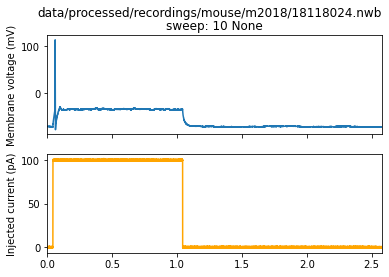

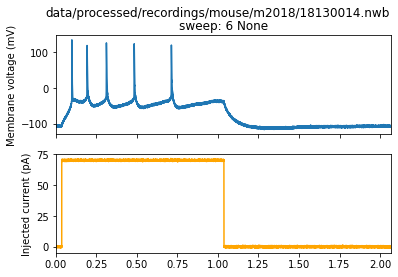

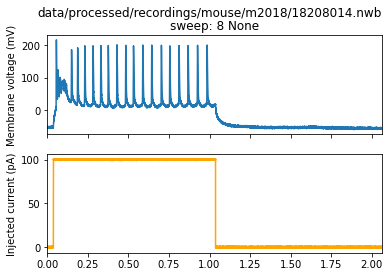

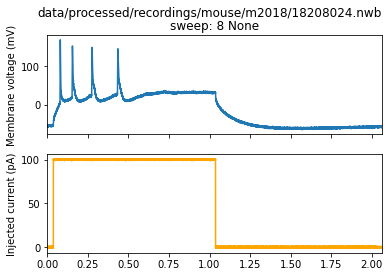

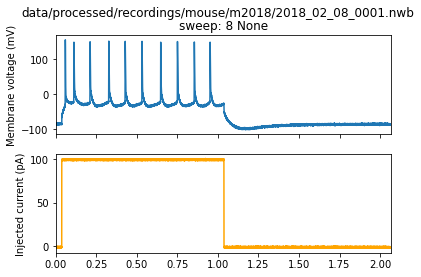

In [54]:
for i, row in nwb_files.sort_values('file_name').iterrows():
    try:
        utils.plot_nwb_sweep(file_name=row.path, ontology=ontology_path)
    except TypeError as e:
        print(e, row.path)